# _Tensorflow implementation of paper "A Neural Algorithm of Artistic Style (2016)_"

#### _This was the breakthrough paper back then 2016. The paper shows that the pretrained convolutional network(such as VGG19) can be used to extract style and content independently from the image. They used these phenomenon to merge the content of a given image with style of reference image. They paper has great visual examples of their results. Here, we are also going to replicate the same. _  

Step 1: Preprocessing the input image

Step 2: Computing the output for selected layers for the content image and all the layers for style image.

Step 3: What is loss function in this problem and computing the loss function.

Step 4: Running Tensorflow model to minimize the loss and optimize the input noise variable.

Step 5: Post processing and displaying the image

Step 6: Automating the stuffs

Step 7: Plotting the successful results.

### Step 1: Preprocessing the input image

_Note: Here, we have used VGG16 layer instead of VGG19 layer (which was used in the paper.) but both can perform the job. Also, as suggested by the authors' of the paper, we have used average pooling instead of max pooling.
Here, because we just want to compute output of convolution layers not fully connected layers, we can have any size of input image we want._


In [1]:
import numpy as np
import helper
import tf_helper
import tensorflow as tf
from PIL import Image
from tensorflow_vgg import vgg16_avg_pool
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Fixing the size for the images to be processed

input_w = 256 # width of input image(original image will be scaled down to this width), width of generated image 
input_h = 256 # height of input image(original image will be scaled down to this height), height of generated image

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### The "helper.py" will help us preprocess and post process the input image. 

#### The "tf_helper.py" will help us compute all the layers-outputs of a given image from VGG16 network. This values will be used later in the actual session. 

Content File


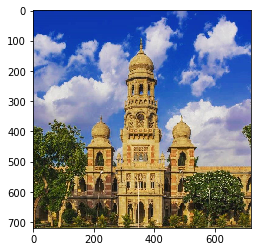

Style File


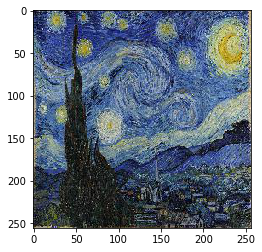

In [11]:
content_file = "./image_resources/content/content_1.jpg"
style_file = "./image_resources/style/style_1.jpg"

output_path = "./image_resources/processed/"

content_output_file = "content_1_processed.jpg"
style_output_file = "style_1_processed.jpg"

# This will scale down the image to given width and height, save it and 
# scale its value to [0-1] as the model expects the input to be between o and 1
# Lastly, it will make a tensorflow ready numpy array with [1, w, h, 3] dims

content_array = helper.resize_and_rescale_img(content_file, input_w, input_h, output_path, content_output_file)
style_array = helper.resize_and_rescale_img(style_file, input_w, input_h, output_path, style_output_file)

i = Image.open(content_file)
j = Image.open(style_file)
print("Content File")
plt.imshow(np.array(i).astype(np.uint8))
plt.show()
print("Style File")
plt.imshow(np.array(j).astype(np.uint8))
plt.show()

### Step 2: Computing the output for all the layers for the input image. (This will be used later in loss function) 

In [13]:
# Here, we will compute the outputs of all the layers for the given texture image.

content_output = tf_helper.compute_tf_output(content_array)
style_output = tf_helper.compute_tf_output(style_array)

D:\LEARN\Deep Learning\4. Style Transfer Paper implementations\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s
[]
All layers' outputs have been computed sucessfully.
D:\LEARN\Deep Learning\4. Style Transfer Paper implementations\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s
[]
All layers' outputs have been computed sucessfully.


### Step 3: What is loss function in this problem and computing the loss function.

#### _Step 3A: Content Loss for reconstruction of the content image._

The content loss is the mean squared difference between feature representation of content image and random noise. The feature representation can be taken from the different layers of the VGG16 model. The each feature representation can be visualized as per below image. Source of the image: https://www.youtube.com/watch?v=CzN_-gVgTno

![](Other resources/Feature representation matrix visualized.PNG)

![](paper/Content Loss.PNG)

Below, we have tried to generate the content of the content image from random noise. As you go throught the results you might notice that as we select deeper layer in VGG16 model the precise representation is getting lost. From initial layers we can generate almost exact image, but as we go deeper the exact detailing is getting lost.

In [14]:
# Only image content reconstruction : Content loss

def content_reconstruction(index, c_output, content_layer_index, name):
    tf.reset_default_graph()

    vgg = vgg16_avg_pool.Vgg16()

    init_rand = tf.random_uniform(shape=content_array.shape, minval=0, maxval=1)
    input_noise_variable = tf.Variable(initial_value=init_rand, name="input_noise", dtype=tf.float32)

    vgg.build(input_noise_variable)

    noise_layers = [vgg.conv1_1, vgg.conv2_1, vgg.conv3_1, vgg.conv4_1, vgg.conv5_1]

    content_part = np.squeeze(c_output[content_layer_index])
    content_part = np.reshape(content_part, (content_part.shape[0] * content_part.shape[1], content_part.shape[2]))

    noise_part = tf.squeeze(noise_layers[index])
    noise_part = tf.reshape(noise_part, (noise_part.shape[0] * noise_part.shape[1], noise_part.shape[2]))
    content_loss =  tf.reduce_sum((noise_part - content_part)**2) / 2

    opt = tf.train.AdamOptimizer().minimize(content_loss)

    epochs = 10000

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        initial_noise = sess.run(input_noise_variable)
        for i in range(epochs):
            _, l = sess.run([opt, content_loss])
            if (i+1) % 1000 == 0:
                print("Epoch: {}/{}, Loss: {}".format(i+1, epochs, l))
        final_noise = sess.run(input_noise_variable)
    # post process the output so that it can be represented properly
    # normalized the data for better visualization
    x = helper.post_process_and_display(final_noise, "./image_resources/outputs/", "content_1_" + name + ".jpg")
    return x

#### Generate output for 5 different configuration - 5 different layers.

In [16]:
content_configs = [0, 3, 6, 10, 14]
content_config_names = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]

content_reconstructions = []
for i in range(len(content_configs)):
    print("Computing for layer: ", content_configs_names[i])
    op = content_reconstruction(i, content_output, content_configs[i], content_config_names[i])
    content_reconstructions.append(op)

Computing for layer:  conv1_1
D:\LEARN\Deep Learning\4. Style Transfer Paper implementations\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s


KeyboardInterrupt: 

#### Visualize the output of different layers

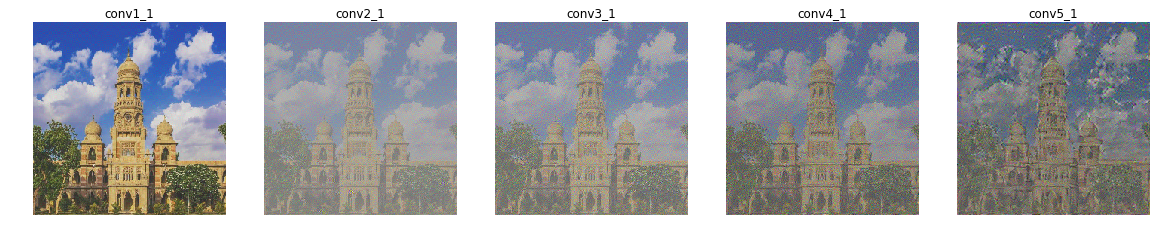

In [46]:
fig = plt.figure(figsize=(20, 20))

cols = len(content_configs)
rows = 1

for j in range(cols*rows):
    fig.add_subplot(rows, cols, j+1)
    plt.imshow(content_reconstruction[j])
    plt.title(content_configs_names[j])
    plt.axis('off')

As you can see, the deeper layer we use, the distorted the reconstruction will be. So, it is better to use the initial layers for the reconstruction of the content image. This insight will be used in the further implementation.

#### _Step 3B: Style Loss for reconstruction of the style from a style image irrespective of content placement of the image._

In [15]:
# Only style reconstruction : Style loss

def style_reconstruction(single_config, s_output, name):
    tf.reset_default_graph()

    vgg = vgg16_avg_pool.Vgg16()

    # It has been observed after multiple attempts that minval = 0 and maxval = 0.2 gives better results instead of minval=0 and maxval=1

    init_rand = tf.random_uniform(shape=content_array.shape, minval=0, maxval=1)
    input_noise_variable = tf.Variable(initial_value=init_rand, name="input_noise", dtype=tf.float32)

    vgg.build(input_noise_variable)

    noise_layers_list = dict({0: vgg.conv1_1, 1: vgg.conv1_2, 2: vgg.pool1, 3: vgg.conv2_1, 4: vgg.conv2_2, 5: vgg.pool2, 6: vgg.conv3_1, 7: vgg.conv3_2, 
               8: vgg.conv3_3, 9: vgg.pool3, 10: vgg.conv4_1, 11: vgg.conv4_2, 12: vgg.conv4_3, 13: vgg.pool4, 14: vgg.conv5_1, 15: vgg.conv5_2, 
               16: vgg.conv5_3, 17: vgg.pool5 })

    style_loss = tf.constant(0, dtype=tf.float32, name="Loss")
    for i in range(len(single_config)):
        style_part = np.squeeze(s_output[single_config[i][0]])
        style_part = np.reshape(style_part, (style_part.shape[0] * style_part.shape[1], style_part.shape[2]))
        style_gram_matrix = np.matmul(style_part.T, style_part)

        noise_part = tf.squeeze(noise_layers_list[single_config[i][0]])
        noise_part = tf.reshape(noise_part, (noise_part.shape[0] * noise_part.shape[1], noise_part.shape[2]))
        noise_gram_matrix = tf.matmul(tf.transpose(noise_part), noise_part)

        style_loss += single_config[i][1] * tf.reduce_sum((noise_gram_matrix - style_gram_matrix)**2) / (4 * style_part.shape[1] * style_part.shape[0])

    style_loss = style_loss / len(single_config)
    
    opt = tf.train.AdamOptimizer().minimize(style_loss)

    epochs = 10000

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        initial_noise = sess.run(input_noise_variable)
        for i in range(epochs):
            _, l = sess.run([opt, style_loss])
            if (i+1) % 1000 == 0:
                print("Epoch: {}/{}, Loss: {}".format(i+1, epochs, l))
        final_noise = sess.run(input_noise_variable)
    # post process the output so that it can be represented properly
    # normalized the data for better visualization
    x = helper.post_process_and_display(final_noise, "./image_resources/outputs/", "style_1_" + name + ".jpg")
    return x 

#### Generate output for 5 different configuration as per paper.

In [8]:
style_configs = [[(0, 1)], [(0, 1), (3, 1)], [(0, 1), (3, 1), (6, 1)], [(0, 1), (3, 1), (6, 1), (10, 1)], [(0, 1), (3, 1), (6, 1), (10, 1), (14, 1)]]
style_config_names = ["conv1_1", "conv1_1 and conv2_1", "conv1_1, conv2_1 and conv3_1", "conv1_1, conv2_1, conv3_1 and conv4_1", "conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1"]

style_reconstructions = []
for i in range(len(style_configs)):
    print("Computing for configuration: ", style_config_names[i])
    op = style_reconstruction(style_configs[i], style_output, style_config_names[i])
    style_reconstructions.append(op)

Computing for configuration:  conv1_1
D:\LEARN\Deep Learning\4. Style Transfer Paper implementations\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s
Epoch: 1000/10000, Loss: 41255444480.0
Epoch: 2000/10000, Loss: 3550649344.0
Epoch: 3000/10000, Loss: 655342080.0
Epoch: 4000/10000, Loss: 185774448.0
Epoch: 5000/10000, Loss: 86754664.0
Epoch: 6000/10000, Loss: 48411744.0
Epoch: 7000/10000, Loss: 27748638.0
Epoch: 8000/10000, Loss: 15899305.0
Epoch: 9000/10000, Loss: 9476311.0
Epoch: 10000/10000, Loss: 6055553.0
Computing for configuration:  conv1_1 and conv2_1
D:\LEARN\Deep Learning\4. Style Transfer Paper implementations\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s
Epoch: 1000/10000, Loss: 23577539641344.0
Epoch: 2000/10000, Loss: 6830942060544.0
Epoch: 3000/10000, Loss: 3391607013376.0
Epoch: 4000/10000, Loss: 1924128047104.0
Epoch: 5000/10000, Loss: 1094335201280.0
Epoch: 6000/10000, Loss: 586463444992.0
Ep

#### Visualize the output of different layers

In [ ]:
fig_ = plt.figure(figsize=(20, 20))

cols_ = len(style_configs)
rows_ = 1

for j in range(cols_*rows_):
    fig_.add_subplot(rows_, cols_, j+1)
    plt.imshow(style_reconstructions[j])
    plt.title(style_config_names[j])
    plt.axis('off')

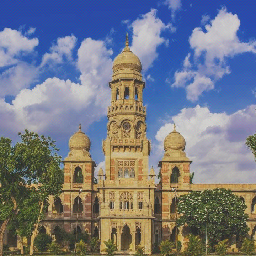

In [30]:
from PIL import Image
mmm = np.squeeze(final_noise)
mmm = (mmm - np.amin(mmm)) / (np.amax(mmm) - np.amin(mmm))

mmm = np.clip(mmm * 255, 0, 255)
mmm = np.array(mmm, np.uint8)
kk = Image.fromarray(mmm)
Image
# conv1_1

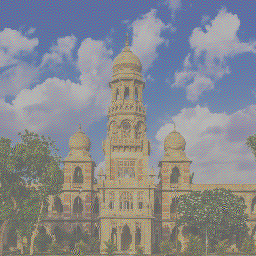

In [32]:
from PIL import Image
mmm = np.squeeze(final_noise)
mmm = (mmm - np.amin(mmm)) / (np.amax(mmm) - np.amin(mmm))

mmm = np.clip(mmm * 255, 0, 255)
mmm = np.array(mmm, np.uint8)
Image.fromarray(mmm)
# conv2_1

In [36]:
from PIL import Image
mmm = np.squeeze(final_noise)
mmm = (mmm - np.amin(mmm)) / (np.amax(mmm) - np.amin(mmm))

mmm = np.clip(mmm * 255, 0, 255)
mmm = np.array(mmm, np.uint8)
KK = Image.fromarray(mmm)
KK.save("./image_resources/outputs/content_1_conv3_1.jpg")
# conv3_1

In [49]:
np.array(content_outputs[0]).shape

(1, 256, 256, 64)

In [55]:
from tensorflow_vgg import vgg16_avg_pool
tf.reset_default_graph()

vgg = vgg16_avg_pool.Vgg16()

#random_ = tf.truncated_normal(shape=content_array.shape, mean=0.5, stddev=0.5)
random_ = tf.random_uniform(shape=content_array.shape, minval=0, maxval=1)

input_noise = tf.Variable(initial_value=random_, name='input_noise', dtype=tf.float32)

vgg.build(input_noise)

noise_layers_list = dict({0: vgg.conv1_1, 1: vgg.conv1_2, 2: vgg.pool1, 3: vgg.conv2_1, 4: vgg.conv2_2, 5: vgg.pool2, 6: vgg.conv3_1, 7: vgg.conv3_2, 
               8: vgg.conv3_3, 9: vgg.pool3, 10: vgg.conv4_1, 11: vgg.conv4_2, 12: vgg.conv4_3, 13: vgg.pool4, 14: vgg.conv5_1, 15: vgg.conv5_2, 
               16: vgg.conv5_3, 17: vgg.pool5 })
""""
# CONTENT LOSS
#def myfxn(m):
    # layer no 11 = conv4_2_7
m = 8

a = tf.squeeze(noise_layers_list[m], 0)
a = tf.reshape(a, shape=(a.shape[0]*a.shape[1], a.shape[2]))

b = np.squeeze(content_outputs[m], 0)
b = np.reshape(b, newshape=(b.shape[0]*b.shape[1], b.shape[2]))
content_loss = tf.reduce_mean((tf.square(tf.subtract(a, b)))/2)
opt = tf.train.AdamOptimizer().minimize(content_loss)
#    return opt

"""    

"""
Style cost

m = 13 # upto layer 5 (excluding layer 5) we want style cost to be calculated
loss = tf.constant(0, dtype=tf.float32, name="Loss")
for i in range(m):
    style_filters = np.squeeze(content_outputs[i], 0)
    style_filters = np.reshape(style_filters, newshape=(style_filters.shape[0] * style_filters.shape[1], style_filters.shape[2]))
    gram_matrix_style = np.matmul(style_filters.T, style_filters)
    
    noise_filters = tf.squeeze(noise_layers_list[i], 0)
    noise_filters = tf.reshape(noise_filters, shape=(noise_filters.shape[0] * noise_filters.shape[1], noise_filters.shape[2]))
    gram_matrix_noise = tf.matmul(tf.transpose(noise_filters), noise_filters)
    
    denominator = (4 * tf.convert_to_tensor(style_filters.shape[1], dtype=tf.float32) * tf.convert_to_tensor(style_filters.shape[0], dtype=tf.float32))
    loss += tf.reduce_sum(tf.square(tf.subtract(gram_matrix_style, gram_matrix_noise))) / tf.cast(denominator, tf.float32)

optimizer = tf.train.AdamOptimizer().minimize(loss)
"""


m = [2, 5, 9, 13]
loss = tf.constant(0, dtype=tf.float32, name="Loss")
for i in range(len(m)):
    style_filters = np.squeeze(content_outputs[m[i]], 0)
    style_filters = np.reshape(style_filters, newshape=(style_filters.shape[0] * style_filters.shape[1], style_filters.shape[2]))
    gram_matrix_style = np.matmul(style_filters.T, style_filters)
    
    noise_filters = tf.squeeze(noise_layers_list[m[i]], 0)
    noise_filters = tf.reshape(noise_filters, shape=(noise_filters.shape[0] * noise_filters.shape[1], noise_filters.shape[2]))
    gram_matrix_noise = tf.matmul(tf.transpose(noise_filters), noise_filters)
    
    denominator = (4 * tf.convert_to_tensor(style_filters.shape[1], dtype=tf.float32) * tf.convert_to_tensor(style_filters.shape[0], dtype=tf.float32))
    loss += 1e-9 * tf.reduce_sum(tf.square(tf.subtract(gram_matrix_style, gram_matrix_noise))) / tf.cast(denominator, tf.float32)

optimizer = tf.train.AdamOptimizer().minimize(loss)


epochs = 25000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(tf.trainable_variables())
    init_noise = sess.run(input_noise)
    for i in range(epochs):
        _, s_loss = sess.run([optimizer, loss])
        if (i+1) % 100 == 0:
            print("Epoch: {}/{}".format(i+1, epochs), " Loss: ", s_loss)
    final_noise = sess.run(input_noise)

D:\LEARN\Deep Learning\2. Visualize CNN Filters and Style Transfer TF\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 0s
[<tf.Variable 'input_noise:0' shape=(1, 256, 256, 3) dtype=float32_ref>]
Epoch: 100/25000  Loss:  6502359.5
Epoch: 200/25000  Loss:  2438458.0
Epoch: 300/25000  Loss:  1003862.25
Epoch: 400/25000  Loss:  546554.3
Epoch: 500/25000  Loss:  337119.9
Epoch: 600/25000  Loss:  227916.31
Epoch: 700/25000  Loss:  165488.39
Epoch: 800/25000  Loss:  125659.22
Epoch: 900/25000  Loss:  98540.39
Epoch: 1000/25000  Loss:  79296.09
Epoch: 1100/25000  Loss:  64991.387
Epoch: 1200/25000  Loss:  54101.14
Epoch: 1300/25000  Loss:  45581.207
Epoch: 1400/25000  Loss:  38761.098
Epoch: 1500/25000  Loss:  33232.895
Epoch: 1600/25000  Loss:  28729.316
Epoch: 1700/25000  Loss:  25042.906
Epoch: 1800/25000  Loss:  22041.076
Epoch: 1900/25000  Loss:  19572.697
Epoch: 2000/25000  Loss:  17518.674
Epoch: 2100/25000  Loss:  15786.864
Epoch: 2200/25000  Loss:  14

Epoch: 22100/25000  Loss:  104.469246
Epoch: 22200/25000  Loss:  104.5559
Epoch: 22300/25000  Loss:  103.8303
Epoch: 22400/25000  Loss:  103.54074
Epoch: 22500/25000  Loss:  103.111565
Epoch: 22600/25000  Loss:  102.81713
Epoch: 22700/25000  Loss:  102.560905
Epoch: 22800/25000  Loss:  102.30347
Epoch: 22900/25000  Loss:  101.9277
Epoch: 23000/25000  Loss:  101.80479
Epoch: 23100/25000  Loss:  101.874016
Epoch: 23200/25000  Loss:  101.077995
Epoch: 23300/25000  Loss:  100.79709
Epoch: 23400/25000  Loss:  100.3977
Epoch: 23500/25000  Loss:  100.09827
Epoch: 23600/25000  Loss:  103.16385
Epoch: 23700/25000  Loss:  99.5033
Epoch: 23800/25000  Loss:  100.93806
Epoch: 23900/25000  Loss:  98.96499
Epoch: 24000/25000  Loss:  98.76057
Epoch: 24100/25000  Loss:  98.4406
Epoch: 24200/25000  Loss:  98.37165
Epoch: 24300/25000  Loss:  98.09631
Epoch: 24400/25000  Loss:  97.64546
Epoch: 24500/25000  Loss:  97.60531
Epoch: 24600/25000  Loss:  97.29228
Epoch: 24700/25000  Loss:  97.034004
Epoch: 2480

In [51]:
from PIL import Image
f = np.squeeze(final_noise)
final_noise_array = (f - f.min() ) / (f.max() - f.min())
    
img = Image.fromarray(final_noise_array, mode='RGB')
img.show()

In [56]:
initial_noise = helper.post_process_and_display(init_noise, "5_initial_noise.jpg")
final_noise_ = helper.post_process_and_display(final_noise, "5_final_noise.jpg")

In [57]:
import winsound
duration = 2000  # millisecond
freq = 440  # Hz
winsound.Beep(freq, duration)

In [58]:
winsound.Beep(freq, duration)